# RL Notes 3: Exploration vs Exploitation

Until now, we used environments were had perfect information: we knew the rewards and transition probabilities. In those context, we could use policy or value iteration to find our optimal policy.

Of course, the interesting case is when we don't have any information whatsoever. We don't know the transition probabilities, and we may not even know the rewards.

Let's briefly review our setting. We're playing a game. This game has certain states we can be in, and actions we can take. We don't know the result of an action. Sometimes we get a reward. We don't know when this happens, but we want more them. l

How do we solve situations like this? We solve them by repeatedly simulating the environment. We use our results estimate the unknown quantities (the fancy name for this technique is Monte Carlo methods).

I discuss some concrete strategies below, but one theme will be common to them all:

### The exploration-exploitation dilemma

At any point we have two options available to us: we can **explore** the possibilities we have, or we can **exploit** the policy we judged so far to be the best. Most strategies will start with exploration in the beginning so that we can gather information. As we do so, we gradually shift towards exploitation of the strategy we judged to be the best.

If we keep on exploring for too long, we waste valuable opportunities to collect rewards.

If we exploit too early, we may be locked into a sub-optimal solution -- had we gathered more information, we could have discovered a better policy.

### Strategies illustrated here

In this post, I will discuss the following, very common policies:
- Greedy
- Explore First, then Greedy,
- Epsilon-Greedy
- Optimistic Initialization
- Optimism in the Face of Uncertainty
- Thompson Sampling

### The Q Function

Many policies will refer in one way or another to the Q function. This function maps state-action combinations to average returns. It is baseically a big lookup table 

## The Environment: Cheating Roulette

### Openai's simple roulette

Openai contains a simplified roulette environment. The rules are as follows:
- You have a roulette wheel with numbers 0-36.
- Every round you can select a number, or you can leave the roulette table, ending the game.
- If you select 0, and it comes up, you receive \$36. If it doesn't come up, you loose \$1.
- If you select a non-zero number, you receive \$1 if the parity of your number matches the parity of the roll (0 doesn't count). Otherwise, you loose \$1. Example: if you select 5 and 17 is rolled you receive \$1.
- Each number has the same probability of showing up.

Simple math will tell you that this roulette has a negative expected value (just as in real life). The best action the agent can take is simply leave the table (again, as in real life)

In [0]:
#!pip install pyglet==1.2.4
#!pip install gym

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
import numpy as np
import pandas as pd
import gym

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [4]:
gym.make('Roulette-v0')  # Openai's original roulette

<TimeLimit<RouletteEnv<Roulette-v0>>>

### Cheating roulette modification

That's not a very interesting setting however. So we will modfiy this roulette. In particular, we will change it so that
- 0 has a 0.033 probability of showing up (instead of ~0.027).
- Every other number is equally likely.
- The payoff is the same as in the original roulette.

The effect of this change is that playing **0** has now positive expected value. However, it is extremely difficult to find out about this feature. After all, even with the modification, 0 will only be rolled once in 30 rounds (on average). 

Moreover, not knowing the **0** cheat (playing policies randomly), the expected value is still negative. That makes leaving the table still attractive, although in this case, suboptimal.

Basically, I have set up an environment where it is easy for an agent to get trapped in a sub-optimal solution (leaving the table).

In [0]:
class CheatingRoulette(gym.envs.toy_text.RouletteEnv):
    '''A modification of the original openai Roulette environment. 
    Here, 0 has positive expected value.'''
    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.n - 1:
            # observation, reward, done, info
            return 0, 0, True, {}

        if np.random.rand() < 0.033:  # Implement cheating
            val = 0
        else:     
            val = self.np_random.randint(1, self.n - 1)
        if val == action == 0:
            reward = self.n - 2.0
        elif val != 0 and action != 0 and val % 2 == action % 2:
            reward = 1.0
        else:
            reward = -1.0
        return 0, reward, False, {}

### The Simulations

I will consider to be a game of roulette to be 100 rounds. The aim is to maximize the money an agent makes in these 100 rounds. Given the finite nature of such a game, I will not apply any discounting.

Each strategy will play 50 000 games (each 100 rounds). After each game, the agent will be able to update its policy.  (Why not update after each round? Because that would dramatically increase computation time, as some strategies rely on the entire history of the game.)

In [0]:
ENV = CheatingRoulette()
GAMMA = 0.9
SIMS = 10000 

## The Policies

Below I create a class that serves as a container for the different policies, defining the common functions among all of them. It contains quite a few lines of code, but will make defining policies much simpler later on.

In [0]:
class Policy(object):
    '''This class is a container for the different policies.
    
    Note: In roulette, states don't matter (and in the openai case, there is
    only 1 state). I still index relevant quantities by state though (for
    example, the Q function), so that this code can easily be extended for other
    environments.
    '''    
    
    def pi(self):
        '''Each policy will have to define this function'''
        raise NotImplementedError
    
    def __init__(self, first_visit = False):
        '''If first_visit is True, returns are updated using first-visit MC,
        otherwise by every-visit MC.'''
        self.first_visit = first_visit
        self.env = ENV
        self.resetAll()   
            
    def next_action(self):
        '''Perform the next action according to policy. Update variables.'''
        self.old_state = self.state
        self.action = self.pi()
        self.action_list[self.episode].append(self.action)
        self.state, self.reward, self.done, _ = self.env.step(self.action)
        self.current_total += self.reward
        self.states_actions_rewards.append((self.old_state, self.action, self.reward))
        
    def playGame(self):
        '''Plays roulette for 100 rounds. This will be considered 1 game.'''
        self.resetGame()        
        for i in range(100):  # play 100 rounds
            self.current_round += 1
            self.next_action()
            if self.done:
                break
        self.updateReturns()
        self.updateQ()
        self.callOnEnd()
        self.episode += 1
        
    def simPolicy(self, n = 10000):
        '''Plays n games of roulette, outputs a list of total rewards.'''
        res = []
        for i in range(n):
            if i % 1000 == 0:
                print('.', end = '')
            self.playGame()
            res.append(self.current_total)
        print('\n')
        return np.array(res)
        
    def resetAll(self):
        '''Reset all variables to default, thereby clearing game history.'''
        self.nA = self.env.action_space.n  # Number of actions
        self.nS = self.env.observation_space.n  # Number of states. For roulette, 1.
        self.episode = 0  # Number of games played (each with 100 rounds)
        self.returns = {}  # Return, given state and action
        # I initialize Q to be random small numbers, as opposed to 0.
        # The reason: Otherwise the argmax function always takes the smallest, giving
        # 0 an unfair edge in the beginning.
        self.Q = np.random.rand(self.nS, self.nA)
        self.Q[0, 37] = 0  # The value for leaving the game is known to be 0.
        for s in range(self.nS):
            for a in range(self.nA):
                self.returns[(s, a)] = []
        self.action_list = []
        self.resetGame()
    
    def resetGame(self):
        '''Resets a single game (but doesn't delete information from game history)'''
        self.state = self.env.reset()
        self.reward = 0
        self.current_round = 0
        self.current_total = 0
        self.done = False
        self.states_actions_rewards = []
        self.states_actions_returns = []
        self.action_list.append([])
        
    def callOnEnd(self):
        '''Optional function that is executed at the end of each game.
        Usually related to updating strategy.'''
        pass
        
    def getStateActionReturns(self):
        '''Calculates the state_action_returns for a single game.'''
        G = 0
        for state, action, reward in reversed(self.states_actions_rewards):
            G = reward + GAMMA * G
            self.states_actions_returns.append((state, action, G))
            
    def updateReturns(self):
        '''Appends returns with the results from the current state_action_returns.
        First-visit and every-visit MC are both possible.'''
        self.getStateActionReturns()
        seen_state_action_pairs = set()
        for state, action, G in self.states_actions_returns:
            sa = (state, action)
            if ~self.first_visit | (sa not in seen_state_action_pairs):
                self.returns[sa].append(G)
                seen_state_action_pairs.add(sa)
        
    def updateQ(self):
        '''Updates our Q function (showing the average return of a state-action combo)'''
        for s in range(self.nS):
            for a in range(self.nA):
                if not self.returns[(s, a)] == []:
                    self.Q[s, a] = np.mean(self.returns[(s, a)])
                    
    def getMaxQ(self):
        '''Returns action with the highest average Q value (highest average return)'''
        return np.argmax(self.Q[self.state, :])

In [0]:
def plotRun(res, title = 'Title', k=5, plot_avg = False):
    x = list(range(len(res)))
    run_avg = list(res[:(k-1)]) + [np.mean(res[i:(i+5)]) for i in range(len(res)-k+1)]
    fig = plt.figure(figsize = (10, 5))
    plt.scatter(x, res, marker = '.')
    if plot_avg: plt.plot(x, run_avg, color = 'black')   
    plt.title(f'Average Profit per Game: {np.mean(res)}')
    plt.suptitle(title)
    
def getResults(pol, title, sims = SIMS):
    res = pol.simPolicy(sims)
    plotRun(res, title)
    
def plotActions(pol, ints = [[0, 1000], [9000, 10000]]):
    legend = [f'Round {sub[0]} - {sub[1]}' for sub in ints]
    l0 = [item for sublist in pol.action_list[ints[0][0]:ints[0][1]] for item in sublist]
    l1 = [item for sublist in pol.action_list[ints[1][0]:ints[1][1]] for item in sublist]
    labels = [legend[0]]*len(l0) + [legend[1]]*len(l1)
    df = pd.DataFrame({'Actions':l0+l1, 'Round':labels})
    print('Actions taken by agent in different rounds')
    axes = df.hist('Actions', by = 'Round', layout = (1, 3), figsize = (15, 3), bins = pol.nA)
    plt.show()

### Basic Benchmark Policies

Before we discuss the strategies listed above, let's have some useful benchmarks.

The first option is to always leave the table; never play. Obviously, that will have a return of 0.

..........



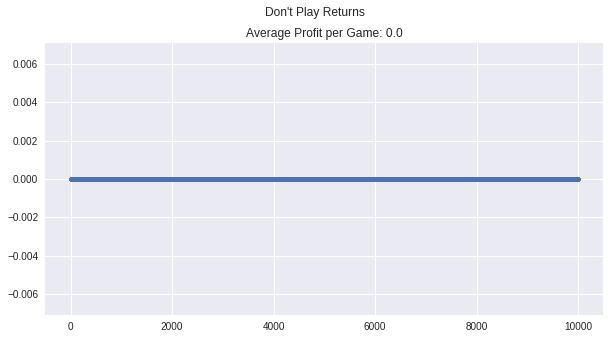

In [9]:
class DontPlay(Policy):      
    def pi(self):
        return 37  # This action is leaving the table
pol = DontPlay()
getResults(pol, "Don't Play Returns")
del(pol)

More interestintly, what if we play in 'God mode', knowing the **0** cheat? In that case, we will earn, on average, about \$11 per game (per 100 rounds).

Below is a plot of the money we earn in each simulated round. Note that even knowing the cheat, in most games we still loose money, as we need 4 zeros per game to get a positive profit. Our positive average is due to the few games where zeros came up many times.

In [0]:
class OptimalPlay(Policy):
    def pi(self):
        return 0

..........



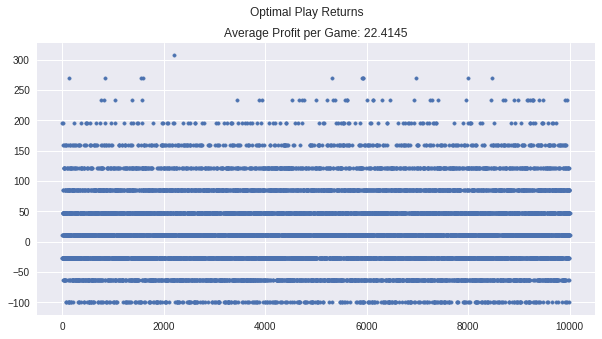

In [11]:
pol = OptimalPlay()
getResults(pol, "Optimal Play Returns")
del(pol)

Just to check, what happens if we always select a random number? The return is somewhat negative: we loose money on average, about \$1 per game (per 100 rounds). 

In [0]:
class RandPolicy(Policy):
    
    def pi(self):
        return self.env.action_space.sample()

..........



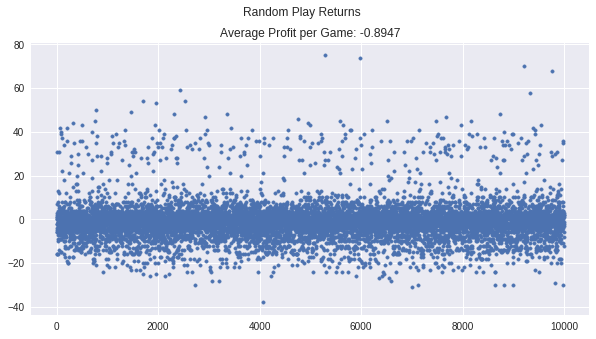

In [13]:
pol = RandPolicy()
getResults(pol, "Random Play Returns")
del(pol)

### Greedy Policy

Our simplest policy is a greedy policy.  A greedy policy simply plays the number with the highest Q value, in this case, with the highest historical return. Generally, it's not a good choice, as it may lock into a sub-optimal solution. 

For roulette, it's actually not that bad. In the beginning, follows random actions, simply because some numbers will, by chance

In [0]:
class Greedy(Policy):

    def pi(self):
        return self.getMaxQ()   

..........



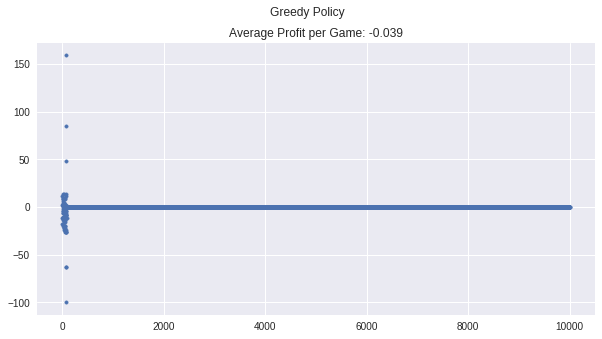

In [18]:
pol = Greedy()
getResults(pol, "Greedy Policy")

Actions taken by agent in different rounds


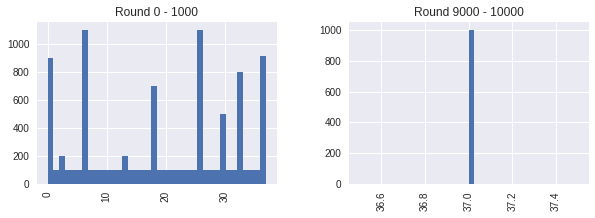

In [19]:
plotActions(pol)

In [0]:
del(pol)

## Explore First Then Greedy

In [0]:
class ExpFirst(Policy):
    
    def __init__(self, exp_num):
        super().__init__()
        self.exp_num = exp_num
    
    def pi(self):
        if self.episode <= self.exp_num:
            # Do exploration
            return self.env.action_space.sample()
        else:
            # Do exploitation
            return self.getMaxQ()         

..........



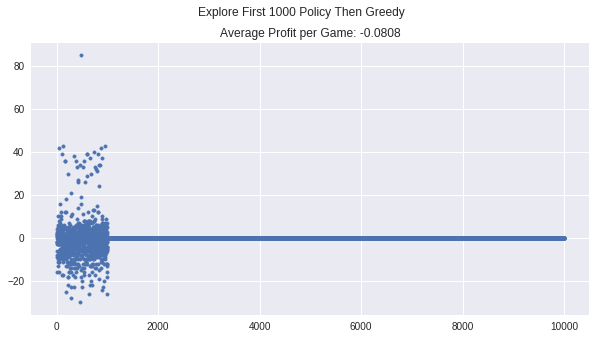

In [22]:
pol = ExpFirst(1000)
getResults(pol, "Explore First 1000 Policy Then Greedy")

Actions taken by agent in different rounds


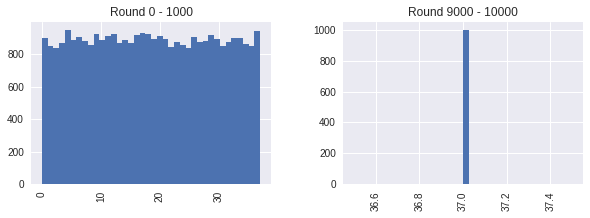

In [23]:
plotActions(pol)

In [0]:
del(pol)

..........



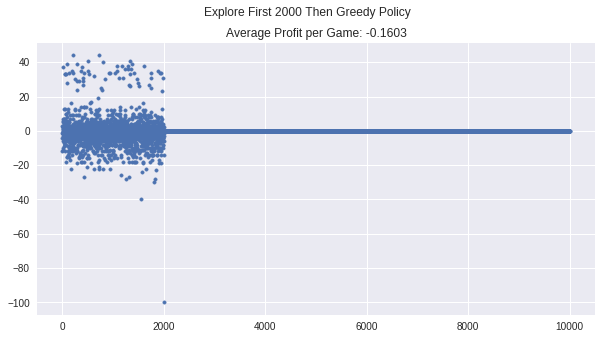

In [25]:
pol = ExpFirst(2000)
getResults(pol, "Explore First 2000 Then Greedy Policy")

Actions taken by agent in different rounds


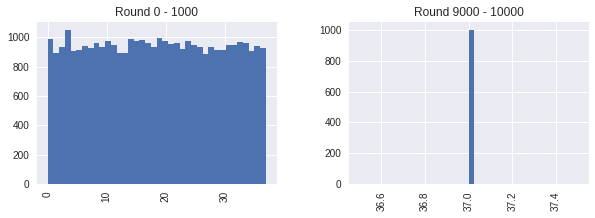

In [27]:
plotActions(pol)

In [0]:
del(pol)

..........



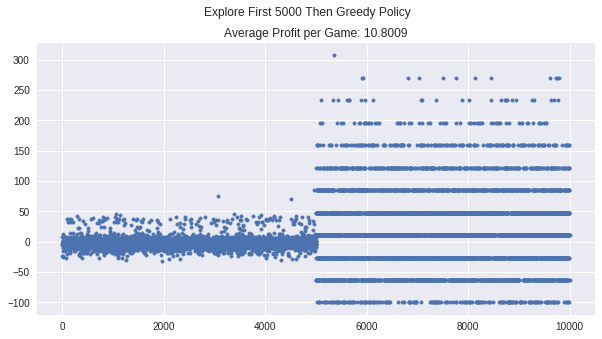

In [29]:
pol = ExpFirst(5000)
getResults(pol, "Explore First 5000 Then Greedy Policy")

Actions taken by agent in different rounds


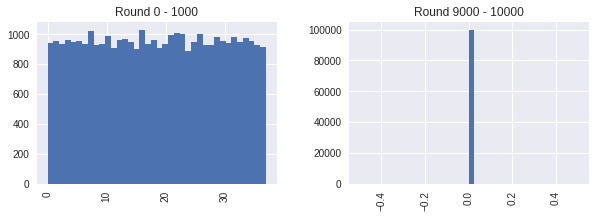

In [30]:
plotActions(pol)

In [0]:
del(pol)

## Epsilon-Greedy

In [0]:
class EpsGreedy(Policy):
    
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def pi(self):
        epsilon = self.k / max(self.episode, 1)
        if np.random.rand() <= epsilon:
            # Do exploration
            return self.env.action_space.sample()
        else:
            # Do exploitation
            return self.getMaxQ()

..........



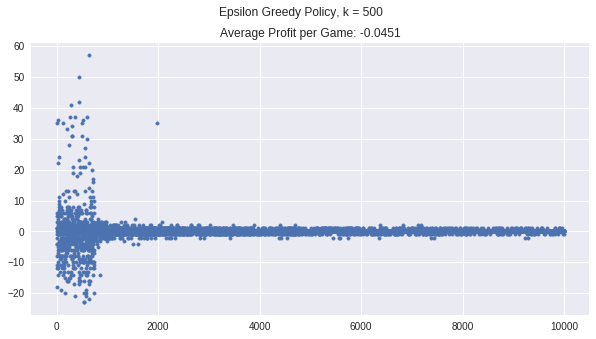

In [33]:
pol = EpsGreedy(500)
getResults(pol, "Epsilon Greedy Policy, k = 500")

Actions taken by agent in different rounds


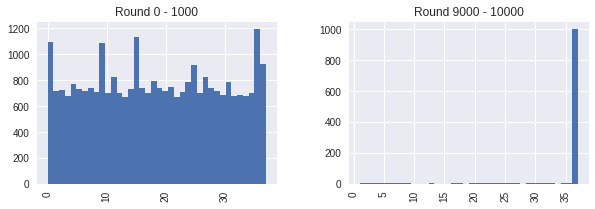

In [34]:
plotActions(pol)

In [0]:
del(pol)

..........



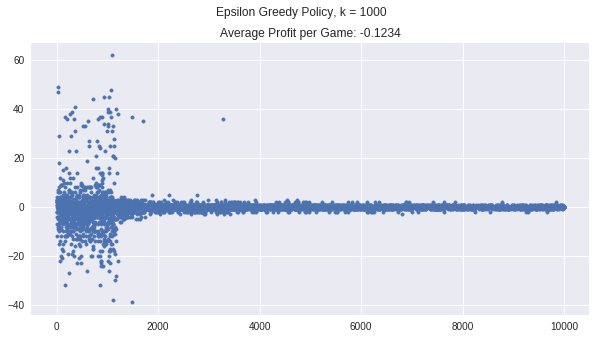

In [36]:
pol = EpsGreedy(1000)
getResults(pol, "Epsilon Greedy Policy, k = 1000")

Actions taken by agent in different rounds


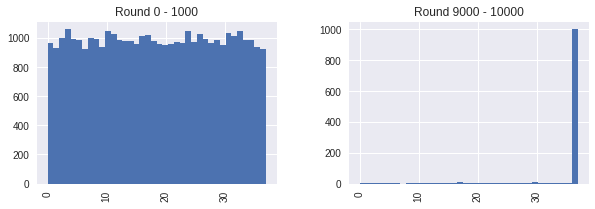

In [37]:
plotActions(pol)

In [0]:
del(pol)

..........



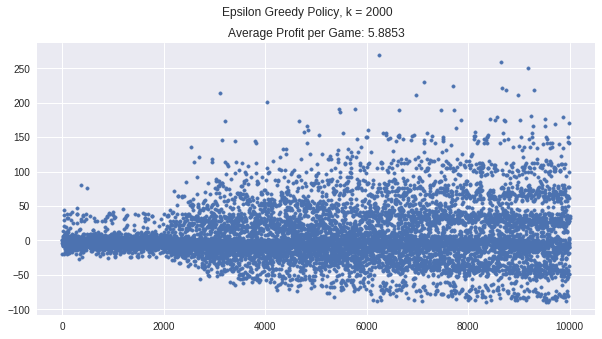

In [39]:
pol = EpsGreedy(2000)
getResults(pol, "Epsilon Greedy Policy, k = 2000")

Actions taken by agent in different rounds


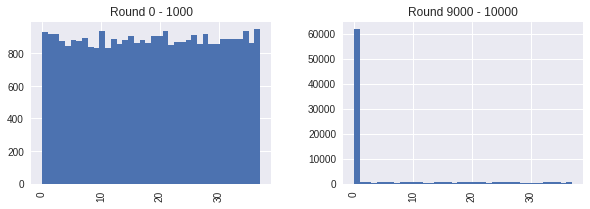

In [40]:
plotActions(pol)

In [0]:
del(pol)

## Optimistic Initialization

In [0]:
class optInitPolicy(Policy):
    
    def __init__(self):
        super().__init__()
        self.Q = 100*np.ones((self.nS, self.nA))
    
    def pi(self):
        return self.getMaxQ()

..........



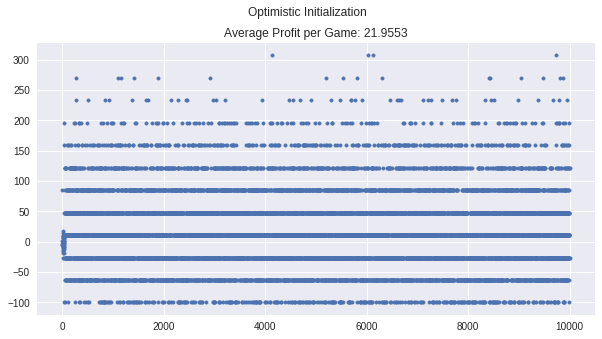

In [46]:
pol = optInitPolicy()
getResults(pol, "Optimistic Initialization")

Actions taken by agent in different rounds


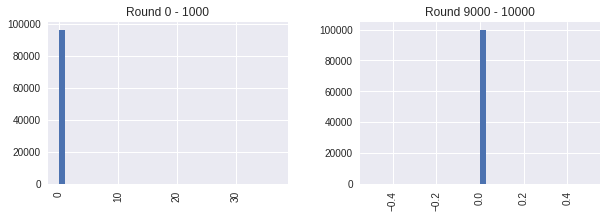

In [47]:
plotActions(pol)

In [0]:
del(pol)

## Optimism in  the Face of Uncertainty

In [0]:
class optUnc(Policy):
    
    def __init__(self, p = 0.05):
        super().__init__()
        self.H = np.ones(self.Q.shape)
        self.H[0, 37] = 0
        self.p = p
        
    def pi(self):
        Q = self.Q[self.state, :]
        H = self.H[self.state, :]
        return np.argmax(Q+H)
        
    def updateH(self):
        for s in range(self.nS):
            for a in range(self.nA):
                if (not self.returns[(s, a)] == []) & (a != 37):
                    n = len(self.returns[(s, a)])
                    self.H[s, a] = np.sqrt(-np.log(self.p)/(2 * n))
             
    def callOnEnd(self):
        self.updateH()

..........



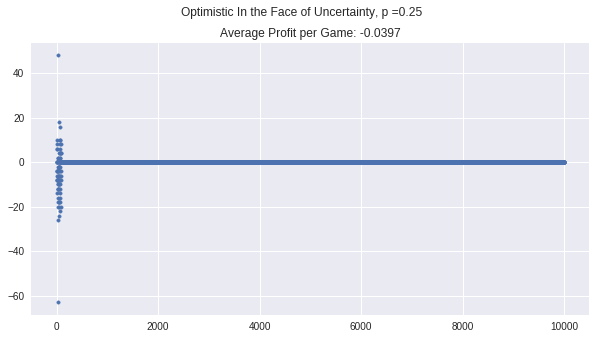

In [52]:
pol = optUnc(p = 0.25)
getResults(pol, 'Optimistic In the Face of Uncertainty, p =0.25')

Actions taken by agent in different rounds


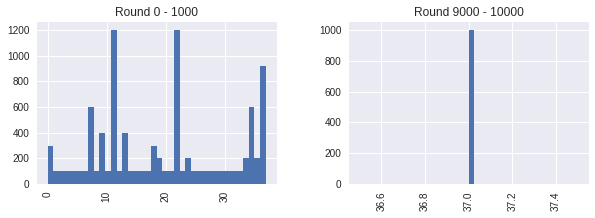

In [53]:
plotActions(pol)

In [0]:
del(pol)

..........



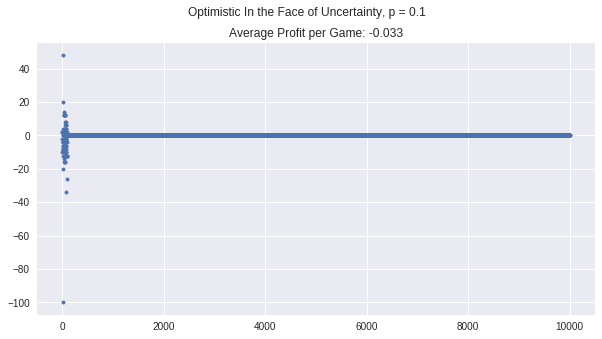

In [55]:
pol = optUnc(p = 0.1)
getResults(pol, 'Optimistic In the Face of Uncertainty, p = 0.1')

Actions taken by agent in different rounds


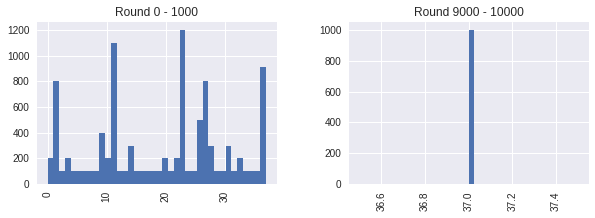

In [56]:
plotActions(pol)

In [0]:
del(pol)

..........



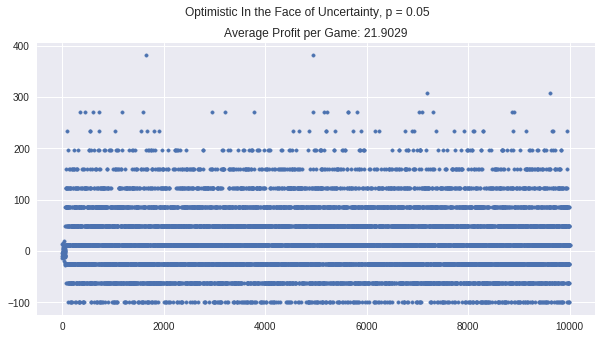

In [58]:
pol = optUnc(p = 0.05)
getResults(pol, 'Optimistic In the Face of Uncertainty, p = 0.05')

Actions taken by agent in different rounds


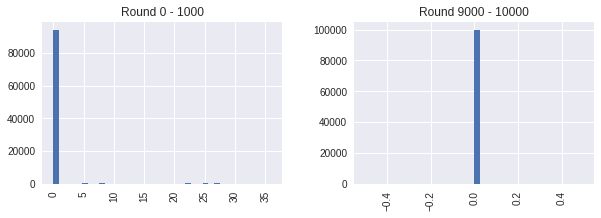

In [59]:
plotActions(pol)

In [0]:
del(pol)

## Thompson Sampling

In [0]:
class optUnc(Policy):
    
    def __init__(self):
        super().__init__()
        self.alphas = np.ones(self.Q.shape)
        self.betas = np.ones(self.Q.shape)
        
    def pi(self):
        
        s = self.state
        n = self.alphas[s, :].shape[0]
        sampl = np.ones(n)/2
        for i in range(n - 1):
            sampl[i] = np.random.beta(self.alphas[s, i], self.betas[s, i])
        self.current_action = np.argmax(sampl)
        return self.current_action
             
    def callOnEnd(self):
        if self.reward > 0:
            self.alphas[self.old_state, self.action] += self.reward
        elif self.reward < 0:
            self.betas[self.old_state, self.action] += -self.reward

..........



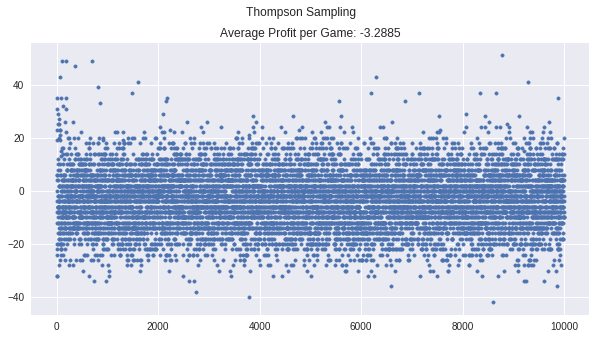

In [76]:
pol = optUnc()
getResults(pol, 'Thompson Sampling')

Actions taken by agent in different rounds


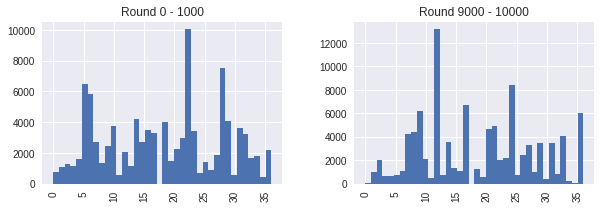

In [78]:
plotActions(pol)